# Homework 3
**Total Points: 5**

**Instructions:**
1. Complete parts 1 through 5, filling in code or responses where marked with `# YOUR CODE HERE` or `# YOUR ANALYSIS HERE`.
2. The libraries you need, in the order you need them, have already been coded. Do not import additional libraries or move import commands.
3. When finished, run the full notebook by selecting <b>Kernel > Restart & Run All</b>. </li>
4. Submit this completed notebook file to <b>NYU Classes</b>. </li>

**Grading:** Each part is worth 1 point.

In [1]:
import numpy as np
import librosa
from matplotlib import pyplot as plt
from scipy import signal
import pandas as pd

import scipy # I added this to use scipy.ndimage.maximum_filter1d() in the onset_detect function
plt.rcParams['figure.figsize'] = (15, 10)  # Setting the figure size for convenient comparison

## Part 1: Energy-Based Novelty Function
Create an energy-based novelty function `energy_novelty()` where the input is an audio signal and the output is the novelty curve of that audio. This function should (1) compute the local energy for each frame, (2) find the first order difference of the local energy, and (3) use half-wave rectification to account only for energy increases. Use `scipy.signal.hann()` to generate a hann window as needed.

In [2]:
def energy_novelty(x, win_size):
    
    """ Calulate an energy-based novelty curve
    
    Parameters
    ----------
    
    x: np.array
        input audio
    
    win_size: int
        samples to advance before next energy calculation
        
    Returns
    -------
    
    novelty: np.array
        novelty curve
        
    """
    # Obtain hann window of size win_size
    window = signal.hann(win_size)
    
    # Placeholder for energy slices to be computed
    x_energy = []
    
    # Inititate a slicing pointer
    start = 0
    
    # Set end point for while point, this discards last few samples that's not of size, if any. 
    while start <= ( len(x) - win_size ) : 
        
        # Compute energy contained in each slice of samples
        E = np.sum( (x[start : start + win_size] * window) ** 2 )
        
        # Appending the energy to an array
        x_energy.append(E)
        
        # Increment the segmentation pointer
        start += win_size
    
    # Converting to numpy array for numpy operations
    x_energy = np.array(x_energy)
    
    # Calculating the difference of energy between each segment of input
    x_energy_diff = np.diff(x_energy)
    
    # Setting negative (energy decrease) values to 0
    x_energy_diff[x_energy_diff < 0] = 0
    
    # Returning the energy difference array
    return x_energy_diff


## Part 2: Spectral Flux Novelty Function
Create a function `spectral_flux_novelty()` where the input is an audio signal and the output is the spectral flux novelty curve of that audio. This function should (1) compute the STFT of the input audio (use `librosa.stft()` where n_fft = win_size and the window type is hann), (2) compress the spectrogram to highlight the high-frequency content, 

In [3]:
# I added gamma as a parameter for flexible experimentation
def spectral_flux_novelty(x, win_size, hop_size, gamma):
    
    """ Calulate a spectral flux novelty curve
    
    Parameters
    ----------
    
    x: np.array
        input audio
    
    win_size: int
        window size (samples)
    
    hop_size: int
        hop size (samples)
        
    Returns
    -------
    
    novelty: np.array
        novelty curve
        
    """
    # Obtain STFT matrix through librosa.stft
    STFT = librosa.core.stft(x, n_fft = win_size, hop_length = hop_size, win_length = win_size, window = 'hann')
    
    # Log scale the frequency axis for better recognition of onsets
    STFT = np.log( 1 + gamma * np.abs(STFT) )
    
    # Sum up the the magnitudes contained in each time slice
    STFT_sum = np.sum(STFT, axis = 0)
    
    # Calculate the differences between each frame, resulting array will be one shorter
    STFT_diff = np.diff(STFT_sum)
    
    # Setting negative values to zero
    STFT_diff[STFT_diff < 0] = 0
    
    # Return the novelty curve
    return STFT_diff

### Test your Novelty Functions
Use the space below to test your novelty function. Plot them to make sure the output appeares as expected. Used the included `drums2.aif` file for. this test

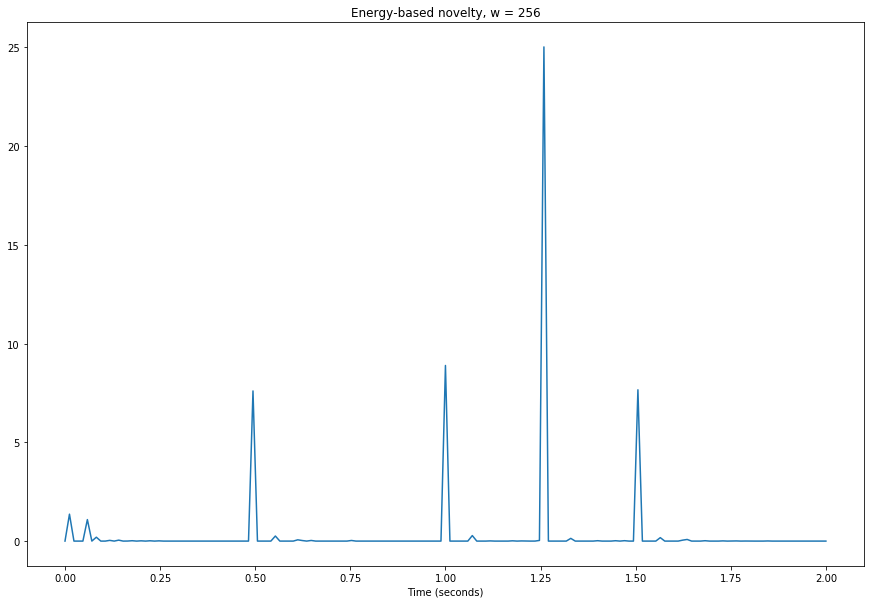

In [4]:
x, fs = librosa.load("audio/drums.aif")

N = len(x)
T = N/fs
e_novelty = energy_novelty(x, 256)
time_vector = np.linspace(0, T, len(e_novelty))

plt.xlabel('Time (seconds)')
plt.title('Energy-based novelty, w = 256')
plt.plot(time_vector, e_novelty)

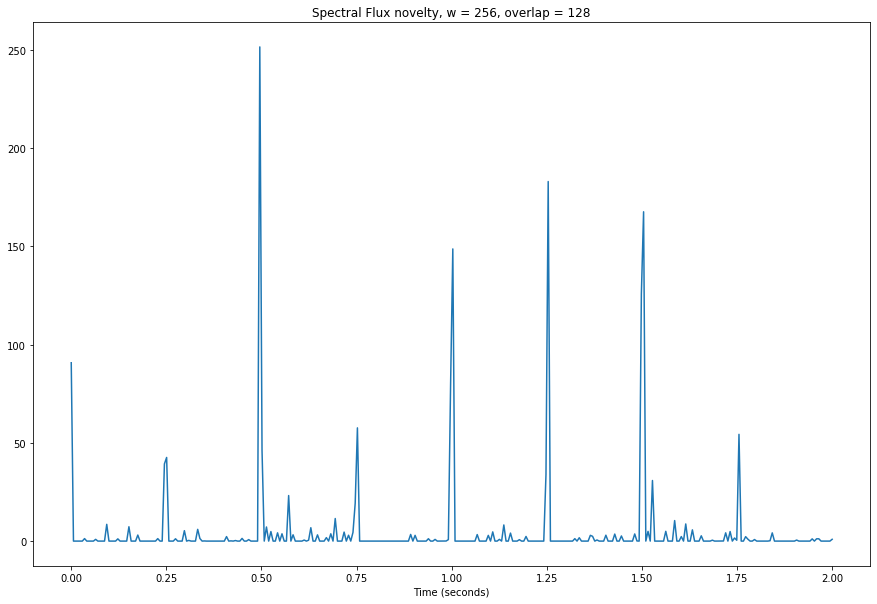

In [5]:
s_novelty = spectral_flux_novelty(x, 256, 128, 10)
time_vector = np.linspace(0, T, len(s_novelty))

plt.xlabel('Time (seconds)')
plt.title('Spectral Flux novelty, w = 256, overlap = 128')
plt.plot(time_vector,  s_novelty)

## Part 3: Detect Onsets
Create a function `detect onsets()` where the input is the novelty curve and the output is a numpy array of estimated onsets.

In [6]:
def detect_onsets (n_fn, mean_len, max_len, delta):
    
    """ Detect onsets from a novelty curve
    
    Parameters
    ----------
    
    n_fn: np.array
        input novelty curve
    
    mean_len: int
        before and after each sample, used to calculate threshold
    
    max_len: int
        window around n used to determine if n is a peak
        
    delta: int
         amount to vertically adjust the threshold (start with delta = 0.05)
      
    
    Returns
    -------
    
    onsets: np.array
        detected onsets (frame number)

    """
    if ( 2 * mean_len + 1 > len(n_fn) ) :
        raise ValueError('mean_len must be less than half of sample length')
    
    if ( max_len > 2 * mean_len + 1 ) :
        raise ValueError('max_len must be no more than than 2 * mean_len + 1')
    
    # Setting up an empty running_average array
    running_average = []
    
    # This calculate the running max by appending the front and end with the smallest value of n_fn
    running_max = scipy.ndimage.maximum_filter1d(n_fn, max_len, mode='constant', cval=n_fn.min())
    
    # Starting at mean_len, this means all samples before this need to be computed later.
    start = mean_len
    
    # This calculates the running average of the samples, excluding front and end mean_len samples
    while (start + mean_len < len( n_fn )) :   
        average = np.mean( n_fn[start - mean_len : start + mean_len] )     
        running_average.append( average )   
        start += 1 
                
    # Calculating the running average of the first mean_len samples
    beginning_average = []
    start = 1
    while start <= mean_len:
        average = np.mean(n_fn[ : start + mean_len])
        beginning_average.append(average)
        start += 1
        
    running_average = np.append(beginning_average, running_average)
        
    # Calculating the ending mean_len samples's running average
    ending_average = []
    start = len(n_fn) - mean_len
    
    while start < len(n_fn) :
        average = np.mean(n_fn[start - mean_len : ])
        ending_average.append(average)
        start += 1
    
    running_average = np.append( running_average, ending_average )
    
    # Visualizing the running average vs original novelty curve
    plt.plot(n_fn, label = 'novelty curve')
    plt.plot(running_average + delta, label = 'running average')
    plt.plot(running_max, label = 'running max')
    plt.legend()
    
    # Finally, compare samples with our running_average and running_max array to determine onsets
    onset_frames = []
    for i in range(0, len(n_fn)):
        if ( n_fn[i] == running_max[i] and n_fn[i] >= ( running_average[i] + delta ) ):
            onset_frames.append(i)
    
    return np.array(onset_frames)

## Part 4: Evaluation
Create a function `evaluate onsets()` where the input is the reference and detected onsets, and the output the precision, recall, and f-measure (see function description for implementation details regarding the output).

In [7]:
def evaluate_onsets(reference_onsets, detected_onsets,tolerance):
    
    """ Calculate the precision, recall, and F-measure of the onsets.
    
    Parameters
    ----------
    
    reference_onsets: np.array
        reference onsets
    
    detected_onsets: np.array
        detected onsets
    
    tolerance: int
        tolerance window (samples)
        
    
    Returns
    -------
    
    eval: np.array
        Three-element np.array with Precusion, Recall, and f-Measure
    
    """
    # ----------------------------------------------------------------------------------------#
    # This implementation assumes that the tolerance windows will not overlap with each other #
    # ----------------------------------------------------------------------------------------#
    
    # Converting the tolerance window from samples to time, assuming fs = 22050
    tolerance = tolerance * (1 / 22050)
    
    # Setting up the tolerance window
    ref_onsets_with_tolerance = []
    
    for onset in reference_onsets:
        onset = [onset - tolerance / 2, onset + tolerance / 2]
        ref_onsets_with_tolerance.append(onset)
    
    # Counting True Positives and False Negatives
    TP = 0 
    FN = 0 
    for ref_onset in ref_onsets_with_tolerance:
        
        for det_onset in detected_onsets:
            
            # if there's any detected onset that fits, increment TP and break the loop
            if det_onset >= ref_onset[0] and det_onset <= ref_onset[1]:
                TP += 1
                break
            
            # if we are at the last detected_onset and there's still no match, increment FN
            if det_onset == detected_onsets[-1]:
                FN += 1
                
    # In this case, false positives would just be detected onsets that are not true positives
    FP = len(detected_onsets) - TP
    
    # Calculating Precision, Recall, F-measure
    
    Precision = TP / (TP + FP)
    
    Recall = TP / (TP + FN)
    
    F_measure = 2 * (Precision * Recall) / (Precision + Recall)
    
    # Returning the results
    return (Precision, Recall, F_measure)

### Test Onsets and Evaluation
Use this section to test your onset detection/peak picking code and your evaluation code. Use `drums2.aif` and the reference onsets below.

Precision, Recall, F-measure =  (1.0, 1.0, 1.0) (tolerance = +-40ms)


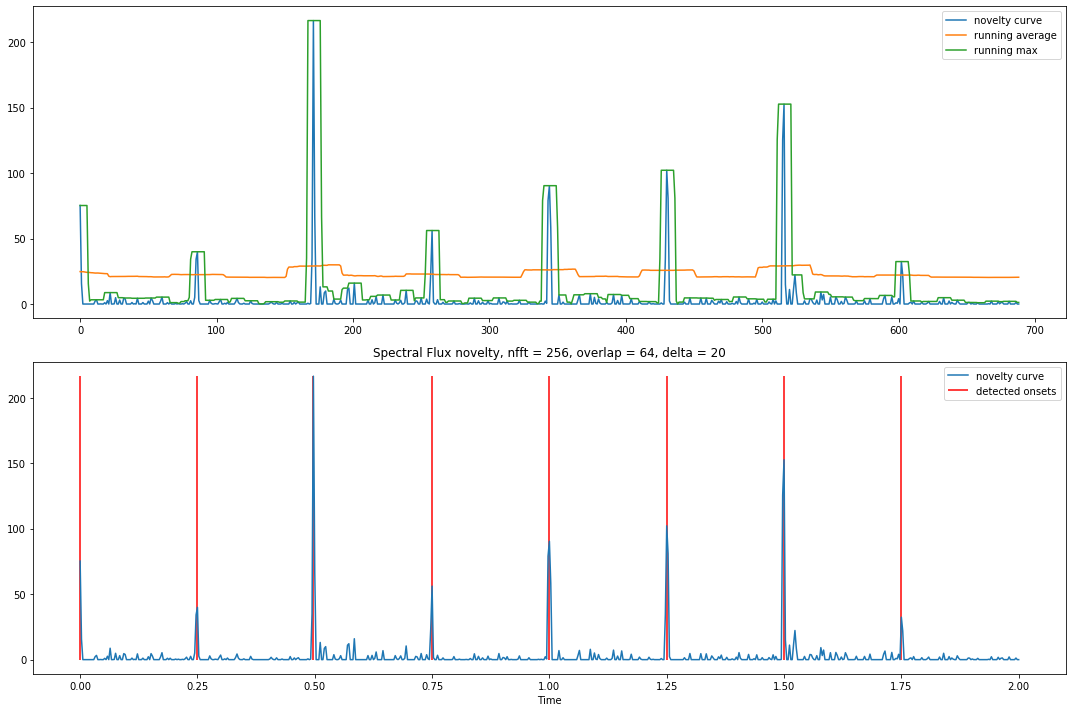

In [29]:
x, fs = librosa.load("audio/drums.aif")
reference_onsets = np.array([0.0, 0.25, 0.5, 0.75,  1.0, 1.25, 1.5, 1.75])
N = len(x)
T = N/fs
e_novelty = energy_novelty(x, 256)
time_vector = np.linspace(0, T, len(e_novelty))

#-------------------------#
# Spectral Flux Curve     #
#-------------------------#
plt.subplot(211)
gamma = 10
s_novelty = spectral_flux_novelty(x, 256, 64, gamma)
time_vector = np.linspace(0, T, len(s_novelty))

#-------------------------#
# Onset-Detection         #
#-------------------------#
delta = 20
onset_frames = detect_onsets(s_novelty, 20, 10, delta)


#-------------------------#
#       Plotting          #
#-------------------------#
plt.subplot(212)
plt.xlabel('Time')
plt.title('Spectral Flux novelty, nfft = 256, overlap = 64, delta = {}'.format(delta))
plt.plot(time_vector,  s_novelty, label = 'novelty curve')
plt.vlines(time_vector[onset_frames], 0, s_novelty.max(), linestyles='solid', color='r', label = 'detected onsets')
plt.legend()
plt.tight_layout()

#-------------------------#
#       Evaluation        #
#-------------------------#
detected_onsets = time_vector[onset_frames]
Evaluations = evaluate_onsets(reference_onsets, detected_onsets, 1764)
print ("Precision, Recall, F-measure = ", Evaluations, "(tolerance = +-40ms)")

from IPython.display import Audio
Audio(data = x, rate = fs)

## Part 5: Analysis
Using the audio files (or your own) files and your code in Parts 1 - 4, report on the novelty function and parameters that generate the most accurate results. In your report, include plots and dataframes as necessary to illustrate your findings. Also comment on the character of each audio file included and how that that character may affect how well (or how poorly) a particular onset detection technique may work. You may use the included files or create your own (less than 10 seconds) audio files for testing.

In [15]:
# Some convenient functions to convert between time and frames.  

# ----------------------------------------------------------- #
def sample_to_ms(num_samples, fs):
    return num_samples * ( 1 / fs ) * 1000

def ms_to_sample(time_in_miliseconds, fs):
    return int ( ( time_in_miliseconds / 1000 ) * fs )

def ms_to_frame(time_in_miliseconds, fs, hop_size):
    samples = ms_to_sample(time_in_miliseconds, fs)
    frames = samples // hop_size
    return frames
# ----------------------------------------------------------- #

In [16]:
ms_to_frame(100, 22050, 256)

8

In [17]:
ms_to_sample(80, 22050)

1764

Precision, Recall, F-measure =  (0.875, 0.875, 0.875) (tolerance = +-40ms)


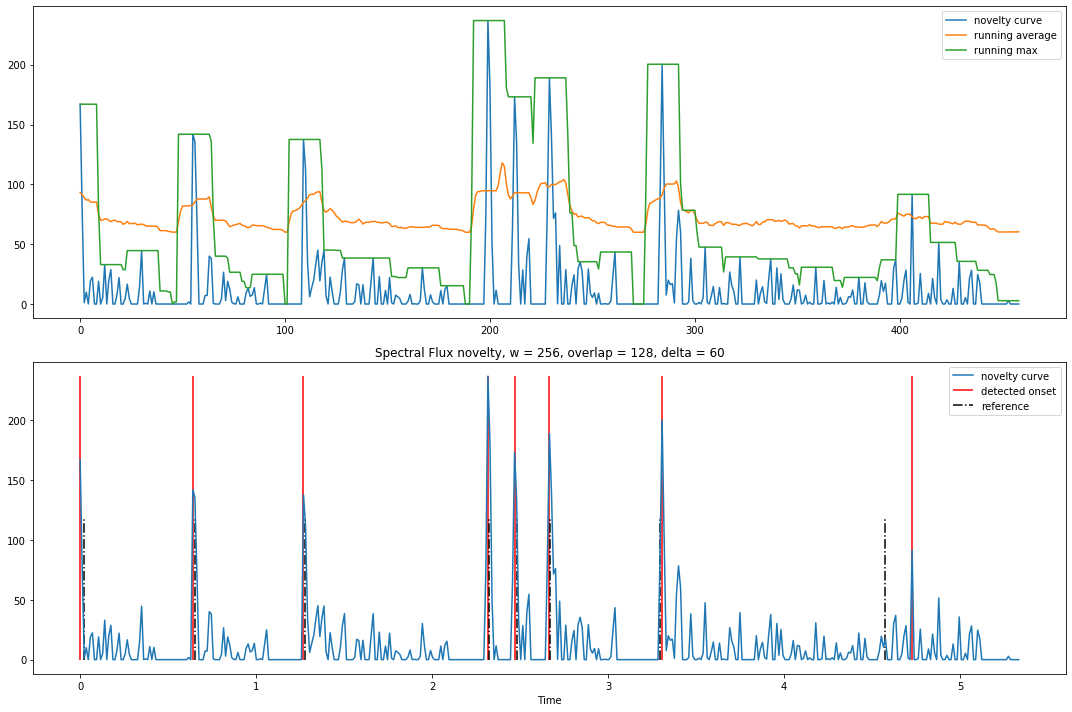

In [20]:
#-----------------------------------------------------------#
#                 Detecting Trumpet Onsets                  #
#-----------------------------------------------------------#

x, fs = librosa.load("audio/trumpet.aif")
reference_onsets = np.array([0.02321995, 0.65015873, 1.27709751, 2.32199546, 2.48453515, 2.67029478, 3.29723356, 4.57433107])
N = len(x)
T = N/fs

#-------------------------#
#   Spectral Flux Curve   #
#-------------------------#
plt.subplot(211)
gamma = 10
s_novelty = spectral_flux_novelty(x, 1024, 256, gamma)
time_vector = np.linspace(0, T, len(s_novelty))

#-------------------------#
#     Onset-Detection     #
#-------------------------#
delta = 60
onset_frames = detect_onsets(s_novelty, 8, 16, delta)


#-------------------------#
#        Plotting         #
#-------------------------#
plt.subplot(212)
plt.xlabel('Time')
plt.title('Spectral Flux novelty, nfft = 1024, overlap = 256, delta = {}'.format(delta))
plt.plot(time_vector,  s_novelty, label = 'novelty curve')
plt.vlines(time_vector[onset_frames], 0, s_novelty.max(), linestyles='solid', color='r', label = 'detected onset')
plt.vlines(reference_onsets, 0, s_novelty.max() / 2, linestyles = 'dashdot', label = 'reference')
plt.legend()
plt.tight_layout()

#-------------------------#
#       Evaluation        #
#-------------------------#
detected_onsets = time_vector[onset_frames]
Evaluations = evaluate_onsets(reference_onsets, detected_onsets, 1764)
print ("Precision, Recall, F-measure = ", Evaluations, "(tolerance = +-40ms)")

from IPython.display import Audio
Audio(data = x, rate = fs)

Precision, Recall, F-measure =  (1.0, 1.0, 1.0) (tolerance = +-40ms)


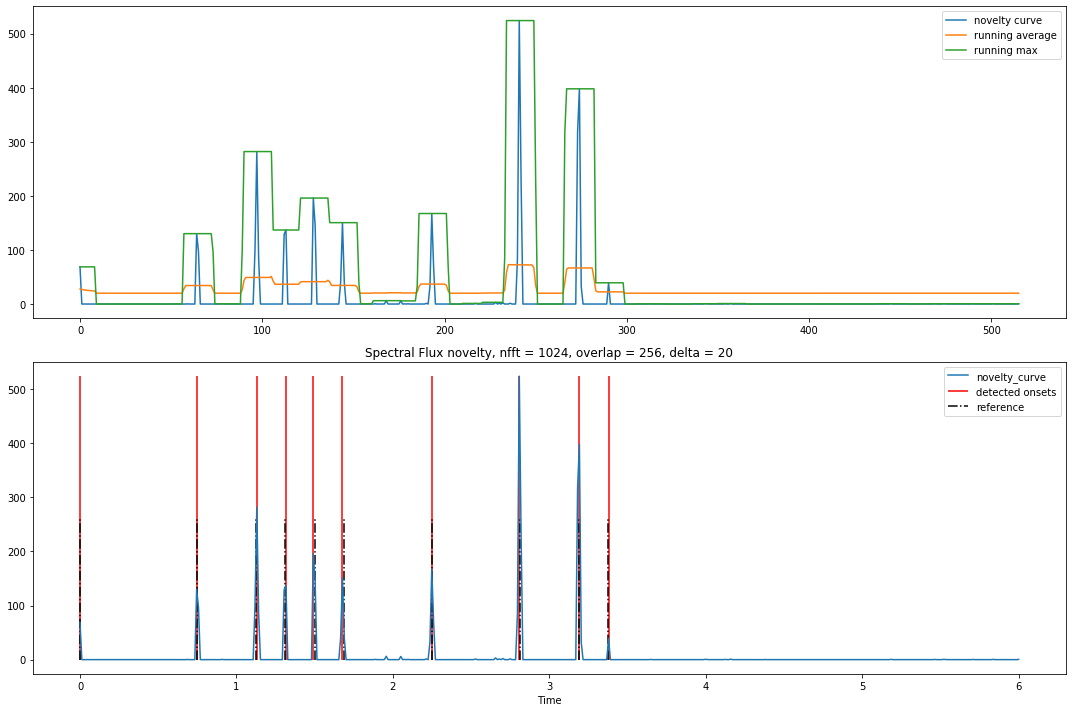

In [24]:
#-----------------------------------------------------------#
#                 Detecting Guitar Onsets                   #
#-----------------------------------------------------------#

x, fs = librosa.load("audio/guitar.aif")
reference_onsets = np.array([0.0, 0.750, 1.125, 1.312, 1.50, 1.688, 2.250, 2.812, 3.188, 3.375])
N = len(x)
T = N/fs

#-------------------------#
#   Spectral Flux Curve   #
#-------------------------#
plt.subplot(211)
gamma = 10
s_novelty = spectral_flux_novelty(x, 1024, 256, gamma)
time_vector = np.linspace(0, T, len(s_novelty))

#-------------------------#
#     Onset-Detection     #
#-------------------------#
delta = 20
onset_frames = detect_onsets(s_novelty, 8, 16, delta)


#-------------------------#
#        Plotting         #
#-------------------------#
plt.subplot(212)
plt.xlabel('Time')
plt.title('Spectral Flux novelty, nfft = 1024, overlap = 256, delta = {}'.format(delta))
plt.plot(time_vector,  s_novelty, label = 'novelty_curve')
plt.vlines(time_vector[onset_frames], 0, s_novelty.max(), linestyles='solid', color='r', label = 'detected onsets')
plt.vlines(reference_onsets, 0, s_novelty.max() / 2, linestyles = 'dashdot', label = 'reference')
plt.legend()
plt.tight_layout()

#-------------------------#
#       Evaluation        #
#-------------------------#
detected_onsets = time_vector[onset_frames]
Evaluations = evaluate_onsets(reference_onsets, detected_onsets, 1764)
print ("Precision, Recall, F-measure = ", Evaluations, "(tolerance = +-40ms)")

from IPython.display import Audio
Audio(data = x, rate = fs)

`YOUR ANALYSIS HERE`